## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSSS'
meas='TOBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
1473
+------------------+-----------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|          coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+-----------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+-----------+------+--------------------+------+
| 717.5459612227578|96.80398671865183| 61.50489335794725|     56.4|BSBSSSSS| 30.7836| -83.5692|       TOBS|0.5299298728719344|0.5218511737391858| 0.515916051091277|0.06153832324130783|USC000972

In [68]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, measurement, latitude,longitude,elevation,%s FROM weather"%feature
#Query="SELECT station, measurement, latitude,longitude,elevation,%s FROM weather GROUP BY MEASUREMENT"%feature
#Query="SELECT latitude,longitude FROM weather"
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, measurement, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+-----------+--------+---------+---------+------------------+
|    station|measurement|latitude|longitude|elevation|           coeff_1|
+-----------+-----------+--------+---------+---------+------------------+
|USC00097276|       TOBS| 30.7836| -83.5692|     56.4| 717.5459612227578|
|USC00093578|       TOBS|  31.615| -85.0494|     64.0|-845.6739032997989|
|USC00013761|       TOBS| 31.3625| -85.3397|    112.8|-696.6960516591588|
|USC00096087|       TOBS| 31.1769| -83.7492|    103.6| 793.2314050286113|
+-----------+-----------+--------+---------+---------+------------------+
only showing top 4 rows

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 43952)
----------------------------------------


Traceback (most recent call last):
  File "/root/anaconda2/lib/python2.7/SocketServer.py", line 290, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/root/anaconda2/lib/python2.7/SocketServer.py", line 318, in process_request
    self.finish_request(request, client_address)
  File "/root/anaconda2/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/root/anaconda2/lib/python2.7/SocketServer.py", line 652, in __init__
    self.handle()
  File "/spark-2.1.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/spark-2.1.0-bin-hadoop2.7/python/pyspark/serializers.py", line 557, in read_int
    raise EOFError
EOFError


In [50]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
26,USC00013761,31.3625,-85.3397,112.8,54,-750.947021
6,USC00014895,31.1000,-85.1667,-999.9,5,627.325120


In [81]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [64]:
min_lat,max_lat,min_long,max_long = box = (29.692222, 31.766336, -85.935267, -82.796108)

In [82]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(1500*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

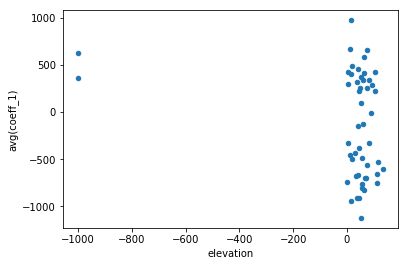

In [54]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');